# Classificar gatos e cachorros 

- Aplicaremos transferência de aprendizagem para reusar os pesos da rede ResNet 50, que é famosa para tarefas de classificação de imagens
- Um modelo pré-treinado no Imagenet da ResNet50 será carregada para classificar novas imagens de gatos e cachorros
- O novo modelo consiste em duas partes: 
    - (1) rede neural base pré-treinada  
    - (2) novas camadas densas
- Citação: Olga Russakovsky, Jia Deng, Hao Su, Jonathan Krause, Sanjeev Satheesh, Sean Ma, Zhiheng Huang, Andrej Karpathy, Aditya Khosla, Michael Bernstein, Alexander C. Berg and Li Fei-Fei. (* = equal contribution) ImageNet Large Scale Visual Recognition Challenge. arXiv:1409.0575, 2014.
- Artigo: https://arxiv.org/abs/1409.0575
- Base de dados: https://www.kaggle.com/tongpython/cat-and-dog

# Etapa 1: Importação das bibliotecas

In [1]:
#%tensorflow_version 2.x   # google colab

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import zipfile
tf.__version__

C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1

'2.3.0'

# Etapa 2: Importação do modelo com os pesos pré-trainados

In [2]:
# ResNet50 é outra arquitetura de rede
model = tf.keras.applications.ResNet50(weights = 'imagenet')

# Etapa 3: Testes com o modelo pré-treinado

- Visualização Imagenet: http://www.image-net.org/synset?wnid=n02835271
- Pesquisa por bicicleta
- https://lear.inrialpes.fr/people/gordo/ImageNetResults/sift1000_accuracy_withPrior/results_sift_0253.htm

In [3]:
# para google colab
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
path = "Transfer-Learning-Data.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [5]:
sample_image = tf.keras.preprocessing.image.load_img(r'./Transfer Learning Data/bicycle.png', target_size=(224,224))

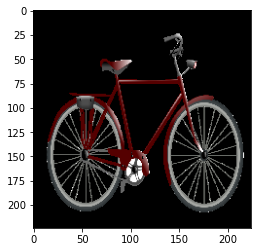

In [6]:
plt.imshow(sample_image)

In [7]:
type(sample_image)

PIL.Image.Image

In [8]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)

In [9]:
type(sample_image)

numpy.ndarray

In [10]:
np.shape(sample_image)

(224, 224, 3)

In [11]:
# expandir as dimensões para possuir 1 dimensão no primeiro eixo
sample_image = np.expand_dims(sample_image, axis=0)

In [12]:
sample_image.shape

(1, 224, 224, 3)

In [13]:
# obtém maior valor
sample_image.max()

255.0

In [14]:
# obtém menor valor
sample_image.min()

0.0

In [15]:
# a mesma estrutura que foi usada para transformar as immagens será aplicada na nossa imagem
sample_image = tf.keras.applications.resnet50.preprocess_input(sample_image)

In [16]:
sample_image.max()

151.061

In [17]:
sample_image.min()

-123.68

In [18]:
predictions = model.predict(sample_image)

In [19]:
# irá trazer as 5 classes com maior probabilidade
print('Predições: ', tf.keras.applications.resnet50.decode_predictions(predictions, top = 5))

Predições:  [[('n02835271', 'bicycle-built-for-two', 0.6329607), ('n03792782', 'mountain_bike', 0.053755853), ('n04482393', 'tricycle', 0.049757946), ('n03599486', 'jinrikisha', 0.015690237), ('n04507155', 'umbrella', 0.010513378)]]


# Etapa 4: Transfer learning e reuso do modelo

In [20]:
# Vamos pegar os pesos do imagenet
# include_top = False não traz a fully connected layer
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

In [21]:
# vamos verificar a estrutura da rede neural
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [22]:
# vamos criar uma nova variável onde iremos criar a rede neural densa e juntar com o modelo base
# teremos a última fase da nossa rede neural
x = base_model.output

In [23]:
# vamos fazer um pooling médio da última camada que estiver vindo
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [24]:
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Como queremos classificar entre gatos e cachorros colocamos o valor igual a 2
# Como são duas classes poderia usar sigmoid ou softmax
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

In [25]:
# a entrada está base_model.input
# a última camada será preds
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [26]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [27]:
# Vamos identificar todas as camadas, pois queremos apenas treinar a parte que adicionamos
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_2 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [28]:
# 0 a 174, pois 175 não entra
# Vamos pedir para não treinar esta parte da rede neural
for layer in model.layers[:175]:
  layer.trainable = False

In [29]:
for layer in model.layers[175:]:
  layer.trainable = True

In [30]:
# Gerador de imagens. É a forma mais fácil de realizar um preprocessamento de imagens em disco
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [31]:
# Agora vamos ler da pasta ./Transfer Learning Data/train e não precisa informar as subpastas cats e dogs
# Ele já vai identificar que são 2 classes com 202 imagens. Neste caso são 101 de gatos e 101 de cachorros
train_generator = train_datagen.flow_from_directory('./Transfer Learning Data/train',
                                                    target_size = (224,224), # rede neural foi treinada nestas características
                                                    color_mode = 'rgb',   
                                                    batch_size = 32, # vai ajustar o peso de 32 em 32 imagens
                                                    class_mode = 'categorical',
                                                    shuffle = True) # mistura as imagens

Found 202 images belonging to 2 classes.


In [32]:
# primeira posição 0 é gato
# segunda posição é cachorro
train_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [33]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# fit_generator onde irá buscar as imagens do diretório
history = model.fit_generator(generator=train_generator,
                              epochs = 10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
7/7 [==============================] - 7s 1s/step - loss: 0.8765 - accuracy: 0.6485
Epoch 2/10
7/7 [==============================] - 8s 1s/step - loss: 0.1032 - accuracy: 0.9703
Epoch 3/10
7/7 [==============================] - 7s 1s/step - loss: 0.0094 - accuracy: 0.9950
Epoch 4/10
7/7 [==============================] - 8s 1s/step - loss: 0.0130 - accuracy: 0.9950
Epoch 5/10
7/7 [==============================] - 11s 2s/step - loss: 0.0129 - accuracy: 0.9901
Epoch 6/10
7/7 [==============================] - 14s 2s/step - loss: 0.0373 - accuracy: 0.9802
Epoch 7/10
7/7 [==============================] - 15s 2s/step - loss: 3.9777e-05 - accuracy: 1.0000
Epoch 8/10
7/7 [==============================] - 15s 2s/step - loss: 0.0373 - accuracy: 0.9851
Epoch 9/10
7/7 [==============================] - 15s 2s/step - loss: 7.8463e-04 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 15s 2

# Etapa 5: Avaliação do modelo

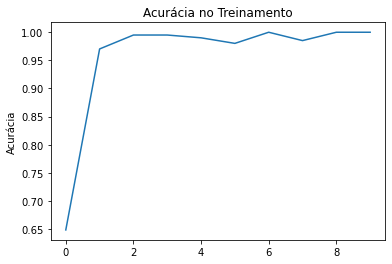

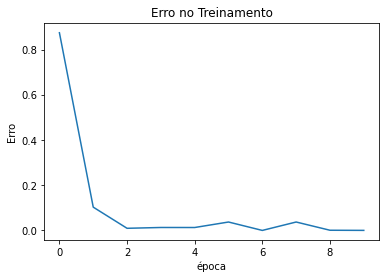

In [35]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Acurácia no Treinamento')
plt.ylabel('Acurácia')
plt.title('Acurácia no Treinamento')

plt.figure()

plt.plot(loss, label='Erro no Treinamento')
plt.ylabel('Erro')
plt.title('Erro no Treinamento')
plt.xlabel('época')
plt.show()

In [36]:
sample_image = tf.keras.preprocessing.image.load_img(r'./Transfer Learning Data/dog.309.jpg', target_size=(224,224))

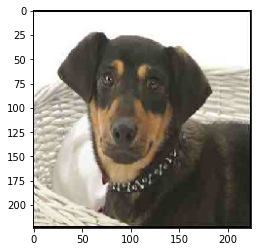

In [37]:
plt.imshow(sample_image)

In [38]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
np.shape(sample_image)

(224, 224, 3)

In [39]:
sample_image = np.expand_dims(sample_image, axis = 0)
np.shape(sample_image)

(1, 224, 224, 3)

In [40]:
sample_image = tf.keras.applications.resnet50.preprocess_input(sample_image)

In [41]:
predictions = model.predict(sample_image)
print(predictions)

[[4.4602665e-08 1.0000000e+00]]


In [42]:
predictions 

array([[4.4602665e-08, 1.0000000e+00]], dtype=float32)

In [43]:
# Primeira posição é gato e a segunda é cachorro
# Probabilidade pequena 1.1325706e-07 de ser gato
# Alta probabilidade de ser cachorro 9.9999988e-01

In [44]:
gato = tf.keras.preprocessing.image.load_img(r'./Transfer Learning Data/cat.282.jpg', target_size=(224,224))

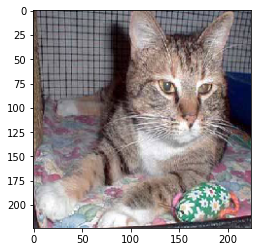

In [45]:
plt.imshow(gato)

In [46]:
gato = tf.keras.preprocessing.image.img_to_array(gato)
np.shape(gato)

(224, 224, 3)

In [47]:
gato = np.expand_dims(gato, axis = 0)
np.shape(gato)

(1, 224, 224, 3)

In [48]:
gato = tf.keras.applications.resnet50.preprocess_input(gato)

In [50]:
predictions = model.predict(gato)
print(predictions)

[[1.000000e+00 5.969082e-10]]
